# Определение возраста покупателей

Краткое описание проекта:

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Задача проекта:

Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Необходимо провести исследовательский анализ набора фотографий и подготовить данные к обучению, а также обучить нейронную сеть и рассчитайте её качество (МАЕ должно быть не ниже 8).

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale=1./255)                                       
train_datagen = datagen.flow_from_dataframe(dataframe=labels,
    directory='/datasets/faces/final_files/',   
    x_col='file_name',
    y_col='real_age',                                         
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [4]:
print("Размер выборки:", len(labels))

Размер выборки: 7591


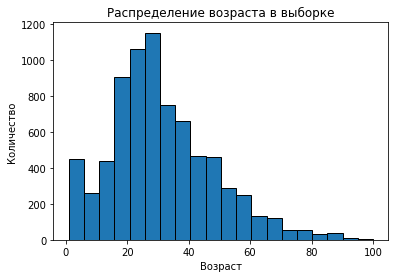

In [5]:
plt.hist(labels['real_age'], bins=20, edgecolor='black')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста в выборке')
plt.show()

Просмотр 15 первых изображений:

In [1]:
#fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
#for i, ax in enumerate(axes.flat):
    #img = plt.imread('/datasets/faces/final_files/' + labels.iloc[i]['file_name'])
    #ax.imshow(img)
    #ax.set_title('Возраст: ' + str(labels.iloc[i]['real_age']))
    #ax.axis('off')
    #if i == 14:
        #break
#plt.show()

Вывод: так как в модели больше всего фотографий людей в возрасте от 20 до 40 лет, соответственно именно люди этого возраста будут определены с большей вероятностью правильно, фотографий людей после 60 не слишком много, поэтому модель может ошибиться из-за недостаточного количества данных. Людей, чей возраст больше 80 еще меньше, соответственно ошибка при определении их возраста может быть еще выше.

## Обучение модели

*Первоначальный код*

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25,
                                 horizontal_flip=True)
    train_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + '/final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=42)
    return train_datagen

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25,
                                 horizontal_flip=True)
    test_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + '/final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=42)
    return test_datagen
   

def create_model():
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation=None))
    model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['mae'])
    
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
        
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2)
    
    return model

```

**Комментарий к правке первоначального кода:**
- аугментацию в тестовой выборке убрала;
- МАЕ использовала намеренно, так как в контексте задачи, модель будет минимизировать именно МАЕ.
- Применяю линейную функцию активации, так как мы ожидаем от модели возраст клиента и просто передаем входные значения без изменений.

- **Эксперимент №1 функция потерь mse, функция активации relu**

60/60 - 11s - loss: 92.1876 - mae: 7.1915
Test MAE: 7.1915

- **Эксперимент №2 функция потерь mse, функция активации None**

60/60 - 11s - loss: 80.0059 - mae: 6.7166
Test MAE: 6.71
Таким образом, лучше заменить МАЕ в функции потерь на MSE (было с МАЕ: 60/60 - 11s - loss: 6.9105 - mae: 6.9094
Test MAE: 6.9094)

- **Эксперимент №3 функция потерь mse, функция активации  tanh**

60/60 - 11s - loss: 1107.3302 - mae: 28.6162
Test MAE: 28.6162

- **Эксперимент №4 использование слоя GlobalAveragePooling2D вместо Flatten**

60/60 - 11s - loss: 89.1308 - mae: 7.1782
Test MAE: 7.1782

- **Эксперимент №5 использование слоя GlobalAveragePooling2D и увеличение кол-во нейронов (в модели и добавим еще один слой с 512 нейронами)**

60/60 - 11s - loss: 8.4558 - mae: 8.4772
Test MAE: 8.4772

- **Эксперимент №6 увеличение кол-ва эпох до 20**

60/60 - 11s - loss: 5.8110 - mae: 5.8030
Test MAE: 5.8030

- **Эксперимент №7 первоночальная модель и увеличение кол-ва эпох до 20**
60/60 - 10s - loss: 63.1681 - mae: 5.8968
Test MAE: 5.8968

**Вывод - в качестве функции активации в данном случае лучше использовать линейную функцию, а для функции потерь можно использовать mse, результат на 0,02 лучше, чем с МАЕ. Также качество модели удалось повысить до 5,80 (было 6.9094) с помощью замены слоя Flatten() на GlobalAveragePooling2D() и добавлением еще 512 нейронов.**

*Улучшенный код*

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25,
                                 horizontal_flip=True)
    train_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + '/final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=42)
    return train_datagen

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25)
    test_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + '/final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=42)
    return test_datagen
   

def create_model(input_shape):
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation=None))
    model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
        
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2)
    
    return model


```

```

Epoch 1/20
2023-04-30 17:28:51.722512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-30 17:28:52.187542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 57s - loss: 10.7822 - mae: 10.7762 - val_loss: 17.2887 - val_mae: 17.2139
Epoch 2/20
178/178 - 44s - loss: 7.1273 - mae: 7.1270 - val_loss: 16.4334 - val_mae: 16.3713
Epoch 3/20
178/178 - 41s - loss: 6.0263 - mae: 6.0265 - val_loss: 14.7739 - val_mae: 14.7010
Epoch 4/20
178/178 - 56s - loss: 5.4816 - mae: 5.4817 - val_loss: 8.4559 - val_mae: 8.4506
Epoch 5/20
178/178 - 58s - loss: 4.9353 - mae: 4.9350 - val_loss: 6.8568 - val_mae: 6.8390
Epoch 6/20
178/178 - 61s - loss: 4.4186 - mae: 4.4187 - val_loss: 6.2662 - val_mae: 6.2492
Epoch 7/20
178/178 - 60s - loss: 4.0840 - mae: 4.0841 - val_loss: 7.3995 - val_mae: 7.3891
Epoch 8/20
178/178 - 61s - loss: 3.9761 - mae: 3.9764 - val_loss: 6.1792 - val_mae: 6.1651
Epoch 9/20
178/178 - 52s - loss: 3.6238 - mae: 3.6240 - val_loss: 6.7641 - val_mae: 6.7396
Epoch 10/20
178/178 - 41s - loss: 3.3873 - mae: 3.3875 - val_loss: 6.4637 - val_mae: 6.4594
Epoch 11/20
178/178 - 40s - loss: 3.2605 - mae: 3.2607 - val_loss: 6.1001 - val_mae: 6.0921
Epoch 12/20
178/178 - 42s - loss: 2.9840 - mae: 2.9840 - val_loss: 6.1655 - val_mae: 6.1643
Epoch 13/20
178/178 - 40s - loss: 2.9180 - mae: 2.9182 - val_loss: 5.9803 - val_mae: 5.9768
Epoch 14/20
178/178 - 40s - loss: 2.7838 - mae: 2.7838 - val_loss: 6.0886 - val_mae: 6.0833
Epoch 15/20
178/178 - 41s - loss: 2.6836 - mae: 2.6833 - val_loss: 5.8764 - val_mae: 5.8632
Epoch 16/20
178/178 - 41s - loss: 2.6091 - mae: 2.6092 - val_loss: 6.0117 - val_mae: 5.9932
Epoch 17/20
178/178 - 41s - loss: 2.5400 - mae: 2.5401 - val_loss: 5.8350 - val_mae: 5.8201
Epoch 18/20
178/178 - 41s - loss: 2.5454 - mae: 2.5455 - val_loss: 6.1822 - val_mae: 6.1772
Epoch 19/20
178/178 - 45s - loss: 2.3825 - mae: 2.3820 - val_loss: 6.2796 - val_mae: 6.2639
Epoch 20/20
178/178 - 60s - loss: 2.3612 - mae: 2.3613 - val_loss: 5.8110 - val_mae: 5.8030
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 5.8110 - mae: 5.8030
Test MAE: 5.8030



```

## Анализ обученной модели

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Для реализации задачи был использован датасет с фотографиями людей, всего изображений 7591. Самый распространенный возраст от 20 до 40 лет, реже встречаются люди в более старшем возрасте, от 60 лет, скорей всего на них модель будет ошибаться чаще, из-за недостатка данных. 

Далее мы использовали предобученную модель ResNet50, и дополнительнительные нейронный слои, в результате ряда эксперементов нам удалось добиться ошибки MAE на тестовой выборке 5,8 , что меньше 7, но недостаточно для достижения эталонного результата в 5,4. Чтоб минимизировать ошибку в дальнейшем необходима более сложная архитектура нейронной сети. 